# **Face Shape classification Model using Self-tuning on fine-tuned networks** <br>


**1Team Member** : Yongbum Park(Team Leader), Yejin Kim, senghyun Kwan, Hojun Kim, Sangjoon Choi <br>
**1Team Github** : https://github.com/1team1768/1team.git<br><br>
**Dataset** : LFW-5590, SCUT-FBP5500_v2.1<br><br>
**Reference** <br> David_Lee's_Science.log<br>  https://www.tensorflow.org/tutorials/load_data/images?hl=ko<br> Unsupervised feature learning for self-tuning neural networks Jongbin Ryu, Ming-Hsuan Yang, Jongwoo Lim(2021)

## **1. Import DataSet**

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import pathlib

In [3]:
data_dir = "/content/drive/MyDrive/face_type/face"
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1535


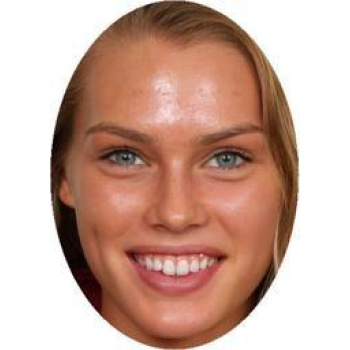

In [5]:
long = list(data_dir.glob('long/*'))
PIL.Image.open(str(long[0]))

## **2. Data Preprocessing**

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1535 files belonging to 5 classes.
Using 1228 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1535 files belonging to 5 classes.
Using 307 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['angulate', 'circle', 'egg', 'long', 'triangle']


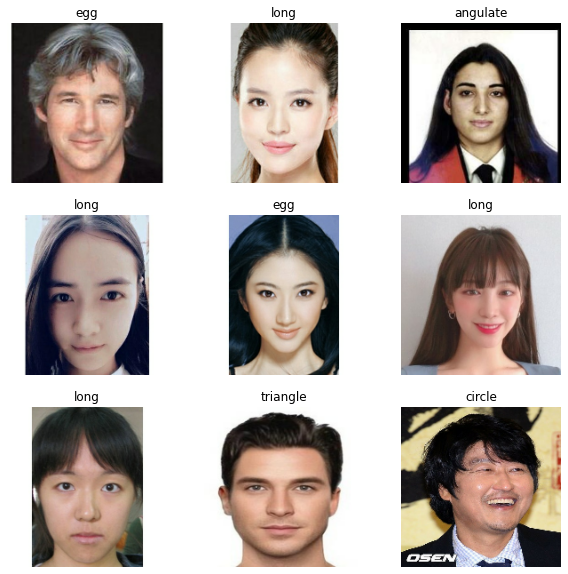

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.11764707 1.0


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Transfer Learning**
<p>base model: Resnet50

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization


base_model = ResNet50(include_top=False, pooling = 'avg' , input_shape = (180,180 ,3), weights = 'imagenet')
base_model.trainable = False

# input_y = tf.keras.utils.to_categorical(train_ds, 5)
# test_y = tf.keras.utils.to_categorical(val_ds, 5)

# 모델 layer 설계
inputs = Input(shape=(180,180,3))
x = tf.keras.layers.experimental.preprocessing.Resizing(180, 180)(inputs)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training = False)
x = Flatten()(x)								
outputs = Dense(5, activation = 'softmax')(x)	 
model_res = tf.keras.Model(inputs, outputs)	

In [16]:
model_res = tf.keras.Model(inputs, outputs)

In [17]:
model_res.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                           

In [18]:
model_res.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

# early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_res.fit(train_ds,validation_data=val_ds, epochs=3)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 8s 95ms/step - loss: 1.1442 - accuracy: 0.5277 - val_loss: 0.7243 - val_accuracy: 0.6971
Epoch 2/3
39/39 [==============================] - 2s 51ms/step - loss: 0.5955 - accuracy: 0.7590 - val_loss: 0.6144 - val_accuracy: 0.7362
Epoch 3/3
39/39 [==============================] - 2s 52ms/step - loss: 0.4916 - accuracy: 0.7980 - val_loss: 0.5773 - val_accuracy: 0.7524


### 3.1 evaluate transfer model

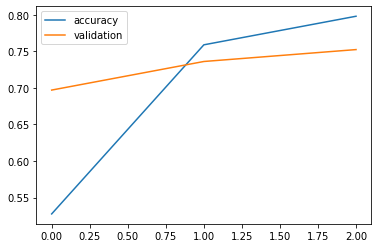

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'validation'], loc = 'upper left')
plt.show()

In [20]:
loss, acc = model_res.evaluate(val_ds,verbose=2)

10/10 - 0s - loss: 0.5773 - accuracy: 0.7524 - 394ms/epoch - 39ms/step


In [21]:
model_res.save('/content/drive/MyDrive/face_type/transfer_model1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/face_type/transfer_model1/assets


## **4. Fine-Tuning**

In [22]:
base_model.trainable = True		# resnet 모델 학습동결을 해제한다
for i in base_model.layers[:143]:	# 143층부터의 학습은 해제상태로 두고, 
  i.trainable = False				# 이전까지의 학습은 동결한다.
  
for i in base_model.layers[140:]:	# 동결이 제대로 해제됐는지 약간 이전층부터 출력해본다.
  print(i.name, i.trainable)

conv4_block6_3_bn False
conv4_block6_add False
conv4_block6_out False
conv5_block1_1_conv True
conv5_block1_1_bn True
conv5_block1_1_relu True
conv5_block1_2_conv True
conv5_block1_2_bn True
conv5_block1_2_relu True
conv5_block1_0_conv True
conv5_block1_3_conv True
conv5_block1_0_bn True
conv5_block1_3_bn True
conv5_block1_add True
conv5_block1_out True
conv5_block2_1_conv True
conv5_block2_1_bn True
conv5_block2_1_relu True
conv5_block2_2_conv True
conv5_block2_2_bn True
conv5_block2_2_relu True
conv5_block2_3_conv True
conv5_block2_3_bn True
conv5_block2_add True
conv5_block2_out True
conv5_block3_1_conv True
conv5_block3_1_bn True
conv5_block3_1_relu True
conv5_block3_2_conv True
conv5_block3_2_bn True
conv5_block3_2_relu True
conv5_block3_3_conv True
conv5_block3_3_bn True
conv5_block3_add True
conv5_block3_out True
avg_pool True


In [32]:
model_res.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

# early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_res.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                           

In [33]:
save_fine = model_res.fit(train_ds, validation_data = val_ds, epochs=10, initial_epoch = history.epoch[-1])

Epoch 3/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 7s 91ms/step - loss: 8.0668 - accuracy: 0.4902 - val_loss: 0.7848 - val_accuracy: 0.6612
Epoch 4/10
39/39 [==============================] - 3s 67ms/step - loss: 0.6420 - accuracy: 0.7239 - val_loss: 0.6239 - val_accuracy: 0.7296
Epoch 5/10
39/39 [==============================] - 3s 68ms/step - loss: 0.5749 - accuracy: 0.7581 - val_loss: 0.6863 - val_accuracy: 0.7199
Epoch 6/10
39/39 [==============================] - 3s 66ms/step - loss: 0.5241 - accuracy: 0.7638 - val_loss: 0.5754 - val_accuracy: 0.7720
Epoch 7/10
39/39 [==============================] - 3s 67ms/step - loss: 0.4566 - accuracy: 0.8046 - val_loss: 0.5828 - val_accuracy: 0.7557
Epoch 8/10
39/39 [==============================] - 3s 66ms/step - loss: 0.4785 - accuracy: 0.7972 - val_loss: 0.5116 - val_accuracy: 0.7655
Epoch 9/10
39/39 [==============================] - 3s 67ms/step - loss: 0.3981 - accuracy: 0.8225 - val_loss: 0.6128 - val_accuracy: 0.7655
Epoch 10/10
39/39 [=====

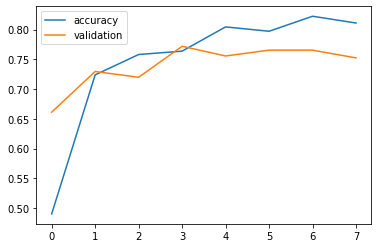

In [34]:
plt.plot(save_fine.history['accuracy'])
plt.plot(save_fine.history['val_accuracy'])
plt.legend(['accuracy', 'validation'], loc = 'upper left')
plt.show()

**fine-tuning 실행 결과 143층 동결 해제 기준 epoch = 6(위 그래프에서는 3)에서 과대적합 되지않은 최적의 성능을 보일것으로 예상**

## **5. Self-Tuning on Fine-Tuned Model**